In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np

import sys
sys.path.append('../support')
import data_functions as dfunc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_style({'font.family': 'sans-serif', 
               'font.sans-serif': 'Arial Narrow', 
               'font.size': 18})

# Load the UCR data

Convert the msa column head to ucrfips so that it will match the crosswalk

In [12]:
dfset = []
for fname in glob.glob('../../Data/ucr_clean/*.csv'):
    tdf = pd.read_csv(fname, index_col = 0, low_memory = False,
                      dtype = {17: object })
    tdf['year'] = int(fname.split('_')[-1].split('.csv')[0])
    dfset.append(tdf)
ucrdf = pd.concat(dfset)
ucrdf.msa = ucrdf.msa.astype(object)
ucrdf.rename(columns = {"msa": "ucrfips"}, inplace=True)

# Load the city msa crosswalk

In [13]:
city_cxdf = pd.read_csv('../../Data/crosswalks/city_msa_crosswalk.csv',
                      dtype = {'msa': object, 'cbsa' : object}, 
                      index_col = 0)
city_cxdf.head()

,City,State,fipst,stategips,ucrfips,fipscounty,cbsa,msa,ssast
0,Montgomery,AL,1,1,1,1001,33860,5240,1
1,Montgomery,AL,1,1,51,1051,33860,5240,1
2,Montgomery,AL,1,1,85,1085,33860,01,1
3,Montgomery,AL,1,1,101,1101,33860,5240,1
4,Miami,FL,12,12,86,12086,33124,5000,10


# Make the area 'name' where two city names are concatenated

In [18]:
names = [','.join(lset) for lset in city_cxdf.loc[:, ['cbsa', 'City', 'State']].values.tolist()]
names = list(set(names))
name_dict = {}
for nset in names:
    cnum, city, state = nset.split(',')
    loc = ','.join([city, state])
    if cnum not in name_dict:
        name_dict[cnum] = []
    name_dict[cnum].append(loc)
for cnum in name_dict:
    name_dict[cnum] = '-'.join(name_dict[cnum])
namedf = pd.DataFrame({'cbsa': list(name_dict.keys()), 'areaname':list(name_dict.values())})
namedf.head()

,areaname,cbsa
0,"Aurora,CO-Denver,CO",19740
1,"Greensboro,NC",24660
2,"Charlotte,NC",16740
3,"Hartford,CT",25540
4,"Louisville,KY",31140


# Cut everything out of the ucr data that isn't in my msa crosswalk by merging

In [20]:
#Make sure ucrfips is an object to match
ucrdf.ucrfips = ucrdf.ucrfips.astype(object)
#Merge it together so that it is annotated with cbsas
ucr_annodf = pd.merge(ucrdf, pd.merge(city_cxdf, namedf, on='cbsa'), on='ucrfips')
#Print it out ot show
ucr_annodf.head()

,id,state_code,ori,group,division,year,sequence_no,age,city_core,covered,...,dec_other2,City,State,fipst,stategips,fipscounty,cbsa,msa,ssast,areaname
0,1,1.0,AL00100,9A,6.0,1960,NaN,16.0,N,NaN,...,0,Montgomery,AL,1,1,1101,33860,5240,1,"Montgomery,AL"
1,1,1.0,AL00100,9A,6.0,1960,NaN,16.0,N,NaN,...,0,Philadelphia,PA,42,42,42101,37964,6160,39,"Philadelphia,PA"
2,1,1.0,AL00100,9A,6.0,1960,NaN,16.0,N,NaN,...,0,Raleigh,NC,37,37,37101,39580,6640,34,"Raleigh,NC"
3,1,1.0,AL00101,4,6.0,1960,7550.0,16.0,N,NaN,...,0,Montgomery,AL,1,1,1101,33860,5240,1,"Montgomery,AL"
4,1,1.0,AL00101,4,6.0,1960,7550.0,16.0,N,NaN,...,0,Philadelphia,PA,42,42,42101,37964,6160,39,"Philadelphia,PA"


# Now everything is merged, so I can try to put it all together by cbsas

So convert 

cbsa year jan feb ....

into:

cbsa year jan murder

cbsa year feb murder


In [30]:
def base_cleaner(x):
    import re
    if type(x) == str:
        last_val = x.split('0')[-1]
        if last_val == '':
            return 0
        else:
            if last_val.isnumeric():
                return int(last_val)
            else:
                #print(last_val)
                return 0
    else:
        return x

mo_names = [m + '_murder' for m in ['jan', 'feb', 'mar', 'apr', 'may', 'jun', \
                                    'jul', 'aug', 'sept', 'oct', 'nov', 'dec']]

year_mon_lines = []
for cbsa in ucr_annodf.cbsa.unique():
    #Get the dataframe for just that cbsa
    cbsa_ucrdf = ucr_annodf[ucr_annodf.cbsa == cbsa]
    for i, mo_name in enumerate(mo_names):
        for year, murder_count in cbsa_ucrdf.loc[:, ['year', mo_name]].values.tolist():
            year_mon_lines.append([cbsa, int(year), i+1, base_cleaner(murder_count)])
#Make it a dataframe
ucrdata = pd.DataFrame(year_mon_lines, columns = ['cbsa', 'year', 'month', 'murder'])
#Drop duplicates
ucrdata.drop_duplicates(inplace=True)

# Now check the annual count

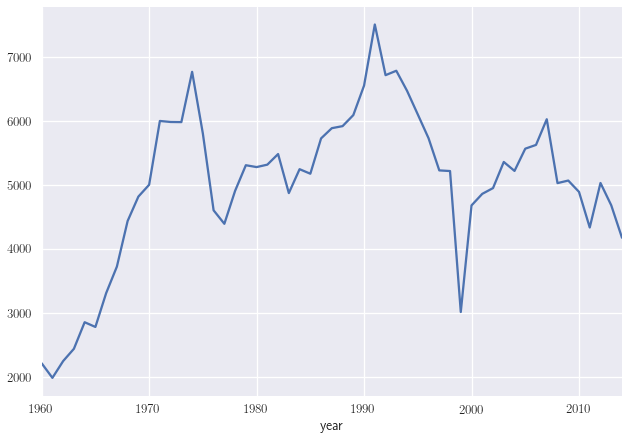

In [33]:
annualdf = ucrdata.groupby('year').agg(sum).loc[:, 'murder'].plot()

# Ahhhh, finally back to something normal

In [43]:
ucr_city = pd.merge(ucrdata, namedf, on='cbsa')

# Checking Chicago area...perfect

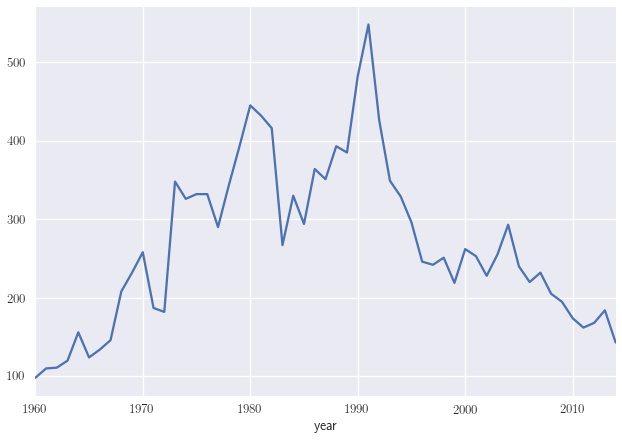

In [45]:
ucr_city[ucr_city.areaname == 'Aurora,IL-Chicago,IL'].groupby('year').agg(sum).loc[:, 'murder'].plot()

# Now I want to condense all months for the same cbsa into one month

In [53]:
agg_ucr_city_month = ucr_city.groupby(['cbsa', 'areaname', 'year', 'month']).agg(sum).reset_index()
agg_ucr_city_month.head()

,cbsa,areaname,year,month,murder
0,10740,"Albuquerque,NM",1970,1,0.0
1,10740,"Albuquerque,NM",1970,2,0.0
2,10740,"Albuquerque,NM",1970,3,0.0
3,10740,"Albuquerque,NM",1970,4,0.0
4,10740,"Albuquerque,NM",1970,5,0.0


# And now condense all months into one year

In [55]:
agg_ucr_city_year = agg_ucr_city_month.groupby(['cbsa', 'areaname', 'year']).agg(sum).loc[:, ['murder']].reset_index()
agg_ucr_city_year.head()

,cbsa,areaname,year,murder
0,10740,"Albuquerque,NM",1970,0.0
1,10740,"Albuquerque,NM",1971,2.0
2,10740,"Albuquerque,NM",1972,0.0
3,10740,"Albuquerque,NM",1973,4.0
4,10740,"Albuquerque,NM",1974,3.0


In [56]:
agg_ucr_city_year.to_csv('ucr_city_yearly.csv')